# LOOCV Risk Function vs Bayesian Ridge posterior

This notebook investigates the shape of the LOOCV risk estimates as a function of $\lambda$, and explores the posterior distribution of the Bayesian ridge hierarchy. In particular, we focus on understanding the quality and quantity of the local minima.

The code presented here is used to generate the plots featured in the NeurIPS poster and presentation slides.

In [1]:
from plotting import *
from RidgeTrueRisk import RidgeTrueRisk
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import pandas as pd 
import os

wd = os.getcwd()

%cd ..
%cd ..
from fastridge import RidgeEM, RidgeLOOCV

%cd $wd

diabetes = load_diabetes()
x, y = load_diabetes(return_X_y=True)

c:\Users\sytew2\Desktop\fastridge\Analysis
c:\Users\sytew2\Desktop\fastridge
c:\Users\sytew2\Desktop\fastridge\Analysis\Unimodality_Convexity


In [2]:
os.getcwd()

'c:\\Users\\sytew2\\Desktop\\fastridge\\Analysis\\Unimodality_Convexity'

## Ridge Regression

Given training data ${\bf X} \in \mathbb{R}^{n \times p}$ and ${\bf y} \in \mathbb{R}^n$, ridge regression finds the linear regression coefficients $\hat{\boldsymbol{\beta}}_\lambda$ that minimize the $\ell_2$-regularized sum of squared errors, i.e., 

\begin{equation}
\hat{\boldsymbol{\beta}}_\lambda = \underset{\boldsymbol{\beta}}{\operatorname{arg\,min}} \left\{ || {\bf y}-{\bf X}\boldsymbol{\beta} ||^2 + \lambda ||\boldsymbol{\beta}||^2 \right\}.\label{eq:ridge_optim}\tag{1}
\end{equation}


In practice, using ridge regression additionally involves estimating the value for the tuning parameter $\lambda$ that minimizes the expected squared error $\mathbb{E}({\bf X}^{\rm T}\!\hat{\boldsymbol{\beta}}_\lambda - y)^2$ for new data ${\bf X}$ and $y$ sampled from the same distribution as the training data.


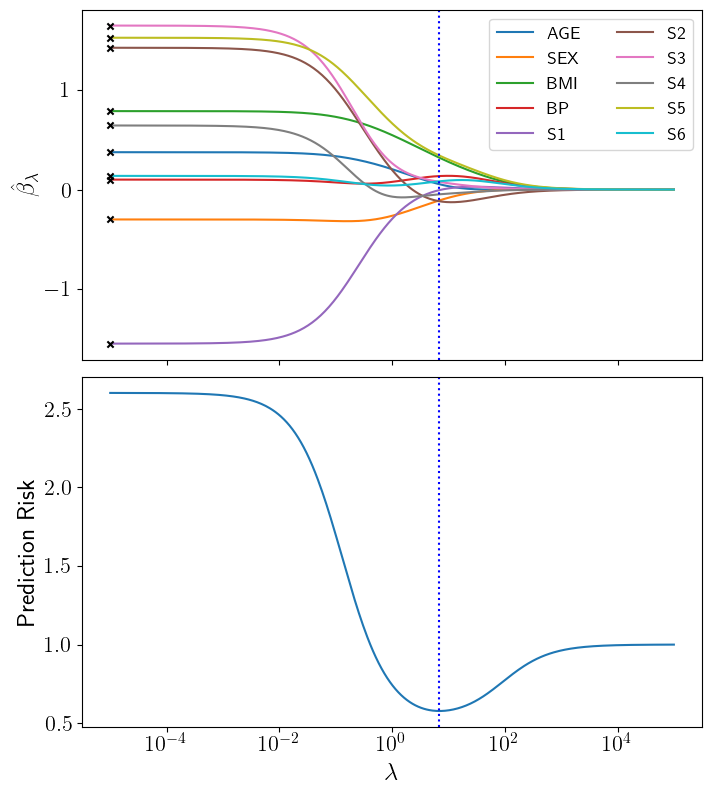

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=20, shuffle=True, random_state=180)

a_x, a_y = (x_train.mean(axis=0), y_train.mean()) 
b_x, b_y = (x_train.std(axis=0), y_train.std())
x_train = (x_train - a_x)/b_x
y_train = (y_train - a_y)/b_y

alphas =np.logspace(-5, 5, 400, endpoint=True, base=10)

ridgeCV_test = RidgeTrueRisk(alphas=alphas, fit_intercept=True, normalize=True)
ridgeCV_test.fit(x_train, y_train, x_test, y_test)

plot_pathway_risk(ridgeCV_test, variable_names = [x.upper() for x in diabetes.feature_names], best_lambda = True, dpi = 100)

When $\lambda = 0$, the ridge estimates recover the regular least squares solutions (marked by the x points in the plot above). Looking at the pathway plot above, you can see that different $\lambda$ values gives different set of regression estimates $\boldsymbol{\beta}_\lambda$, which in turns, yields different predictive performance on the test dataset. Some estimates of $\boldsymbol{\beta}_\lambda$ gives overall better predictive performance than others. Consequently, the objective is to estimate the optimal $\lambda$ (dotted blue horizontal line) from the training data.

This problem is usually approached via the leave-one-out cross-validation (LOOCV) estimator. However, as discussed in the follwing section, this approach exhibits two weaknessess: (i) its risk function can be multimodal, and (ii) the global minima can be far away from the true optimal $\lambda$, resulting in high prediction error. 

## LOOCV Risk

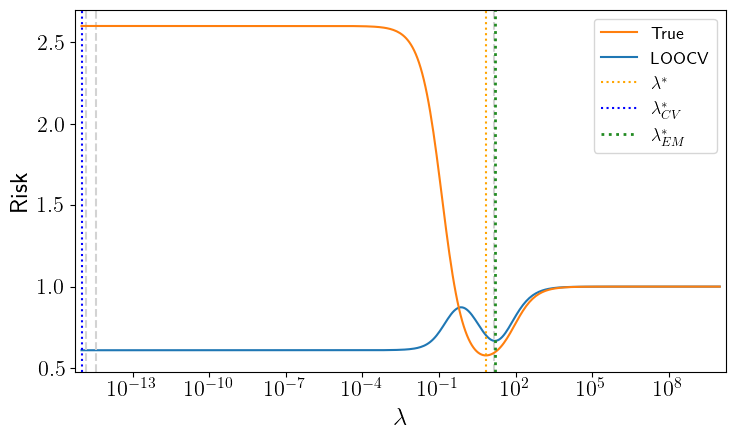

In [15]:
N = 400
alphas =np.logspace(-15, 10, N, endpoint=True, base=10)

ridgeCV = RidgeLOOCV(alphas=alphas, fit_intercept=True, normalize=True)
ridgeCV.fit(x_train, y_train)

ridgeCV_test = RidgeTrueRisk(alphas=alphas, fit_intercept=True, normalize=True)
ridgeCV_test.fit(x_train, y_train, x_test, y_test)

#compare it to the proposed EM ridge procedure
ridgeEM = RidgeEM(trace = True)
ridgeEM.fit(x_train, y_train)

plot_lambda_risks(ridgeCV, ridgeCV_test, ridgeEM = ridgeEM, title = None, localmin = True, dpi = 100)

plt.show()

In the plot above, we observe multiple local minima (grey dotted lines) in the LOOCV risk function, with the global minimum (blue dotted line) notably far from the true optimal $\lambda$ (orange dotted line). In contrast, the proposed EM procedure identifies an optimal $\lambda$ that is close to the true optimal. Subsequent visuals in the next section illustrates the theoreom presented in the paper, highlighting that for sufficiently large $n$ and $\tau^2$ being far enough away from zero, the joint posterior of the Bayesian ridge is unimodal.

## Bayesian Ridge

The ridge estimator has a well-known Bayesian interpretation; specifically, if we assume that the coefficients are <em>a priori</em> normally distributed with mean zero and common variance $\tau^2 \sigma^2$ we obtain a Bayesian version of the usual ridge regression procedure, i.e., 

\begin{align*}
\begin{split}
    {\bf y}\,|\,{\bf X}, \boldsymbol{\beta}, \sigma^2 \; &\sim \; N_n\left({\bf X}\boldsymbol{\beta}, \; \sigma^2{\bf I}_n\right),\\ 
    \boldsymbol{\beta}\,|\,\tau^2, \sigma^2 \; &\sim \; N_p\left(0, \; \tau^2 \sigma^2{\bf I}_p\right),\\ 
    \sigma^2 &\sim \sigma^{-2} d\sigma^2, \\
    \tau^2 \; &\sim \; \pi(\tau^2)d\tau^2. 
\end{split}
\end{align*}

With $\tau > 0$ and $\sigma>0$, the conditional posterior distribution of $\boldsymbol{\beta}$ is normal

\begin{align*}
\begin{split}
    \boldsymbol{\beta}\,|\,\tau^2,\sigma^2,{\bf y} \; &\sim \; N_p(\hat{\boldsymbol{\beta}}_{\tau}, \; \sigma^2{\bf A}_{\tau}^{-1}),\\
    \hat{\boldsymbol{\beta}}_{\tau} &= {\bf A}_{\tau}^{-1}{\bf X}^{\rm T}{\bf y}, \\
    {\bf A}_{\tau} \; &= \; ({\bf X}^{\rm T} {\bf X} +  \tau^{-2} {\bf I}_p),
\end{split}
\end{align*}

where the posterior mode (and mean) $\hat{\boldsymbol{\beta}}_{\tau}$ is equivalent to the ridge estimate ([1](#mjx-eqn-eq:ridge_optim)) with penalty $\lambda = 1/\tau^2$.


The key idea now is to maximize the marginal posterior for $\tau^2$ and $\sigma^2$:

\begin{align*}
\begin{split}
    &\underset{\tau^2, \sigma^2}{\operatorname{arg\,min}}\left[-\log \pi(\tau^2, \sigma^2)\int p({\bf y}| {\bf X}, \boldsymbol{\beta}, \tau^2, \sigma^2) \pi(\boldsymbol{\beta}| \tau^2, \sigma^2) d\boldsymbol{\beta} \right] \\
    &= \underset{\tau^2, \sigma^2}{\operatorname{arg\,min}}[-\log p(\tau^2, \sigma^2| {\bf y}, {\bf X})]
\end{split}
\end{align*}


And one approach to do this is by using the EM algorithm to iteratively estimate the hyperparameters $\tau^2$ and $\sigma^2$ by minimizing the expected log posterior, with the regression coefficients $\boldsymbol{\beta}$ treated as latent variable: $$
    \{\hat{\tau}^2_{t+1}, \hat{\sigma}^{2}_{t+1} \} = \underset{\tau^2, \sigma^2}{\operatorname{arg\,min}} \,  \mathbb{E}_{\boldsymbol{\beta}}[-\log p(\boldsymbol{\beta}, \tau^2, \sigma^2| {\bf y}, {\bf X}) | \hat{\tau}^2_{t}, \hat{\sigma}^{2}_{t} ] .$$





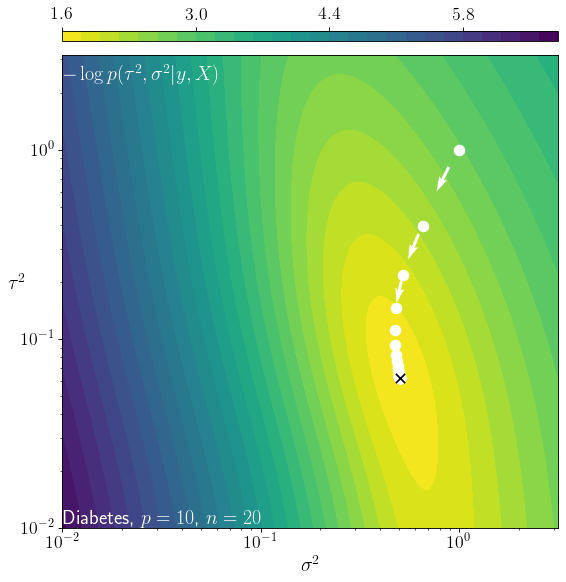

In [16]:
ridgeEM = RidgeEM(trace = True)
ridgeEM.fit(x_train, y_train)

N = 100
sig2 = np.logspace(-2, 0.5, N) 
t2 = np.logspace(-2, 0.5, N) 

#print("EM_tau2 = ", ridgeEM.tau_square_, " EM_sigma2 = ", ridgeEM.sigma_square_)

z = compute_marginal_likelihood(x_train, y_train, sig2, t2, ridgeEM.sigma_square_, ridgeEM.tau_square_)


plot_EM_step(z, sig2, t2, ridgeEM.sigma_square_, ridgeEM.tau_square_, 
             levels = 30, sigma_squares = ridgeEM.sigma_squares_, tau_squares = ridgeEM.tau_squares_, 
             log = True, title = 'Diabetes, $p=10$, $n=20$', dpi = 80)

In the paper, we presented the following theorem:

**Theorem 3.1** *Let $\epsilon > 0$, and let $\gamma_n$ be the smallest eigenvalue of ${\bf X}^{\rm T}{\bf X}/n$. If $\gamma_n > 0$ and $\epsilon > 4/(n\gamma_n)$ then the joint posterior
$p(\boldsymbol{\beta}, \sigma^2, \tau^2 | {\bf y})$ has a unique mode with $\tau^2 \geq \epsilon$.
In particular, if $\gamma_n \geq cn^{-\alpha}$ with $\alpha < 1$ and $c>0$ then there is a unique mode with $\tau^2 \geq \epsilon$ if $n > (4/(c\epsilon))^{1/(1-\alpha)}$.*

This suggest that all sub-optimal non-zero posterior modes vanish for large enough $n$ if the smallest eigenvalue of ${\bf X}^{\rm T} {\bf X}$ grows at least proportionally to some positive power of $n$. This is a very mild assumption that is typically satisfied in fixed as well as random design settings, e.g., with high probability when the smallest marginal covariate variance is bounded away from zero.

Here we attempt to visualise this fact by plotting the **marginal posterior profile** for $\tau^2$. 

<sup>(Note) *We are guided by the notion that if the joint distribution exhibits unimodality in a given domain, then the individual marginal distributions will be unimodal as well. This hypothesis forms the basis of our investigation, as we endeavor to validate or challenge its validity through future analysis.*</sup>

### Marginal posterior profile

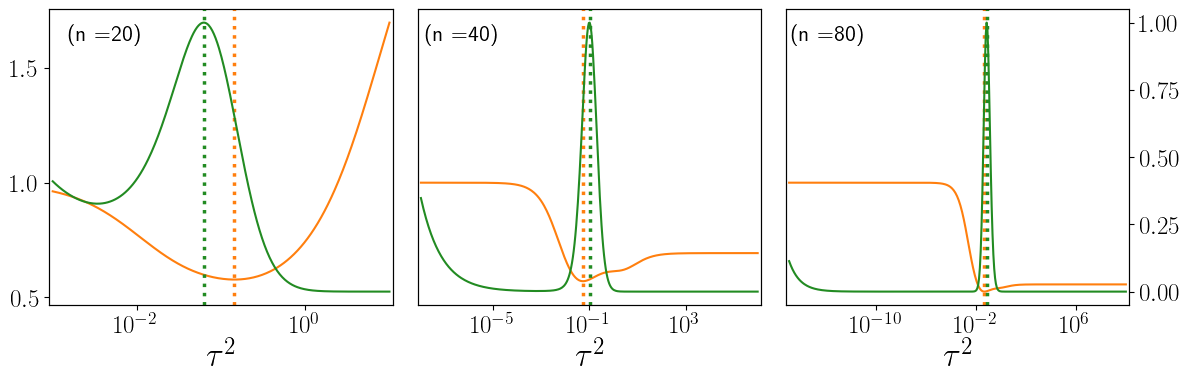

In [3]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

N = 400

n_size = [20, 40, 80]
t2_lowerlimit = [-3, -8, -17]
t2_upperlimit = [1, 6, 10]

_, axs = plt.subplots(1, len(n_size), tight_layout=True, figsize=(12, 4), sharey=True, dpi=100)

for i, s in enumerate(n_size):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=s, shuffle=True, random_state=180)
    alphas = 1/np.logspace(t2_lowerlimit[i], t2_upperlimit[i], N, endpoint=True, base=10)

    a_x, a_y = (x_train.mean(axis=0), y_train.mean()) 
    b_x, b_y = (x_train.std(axis=0), y_train.std())
    x_train = (x_train - a_x)/b_x
    y_train = (y_train - a_y)/b_y
    
    #ridgeEM = RidgeEM(trace = True)
    #ridgeEM.fit(x_train, y_train)
    #print(ridgeEM.tau_square_) - to double check, you will see that this value is identical to the green vertical line 
    
    ridgeCV_test = RidgeTrueRisk(alphas=alphas, fit_intercept=True, normalize=True)
    ridgeCV_test.fit(x_train, y_train, x_test, y_test)
    ridgeCV_test.alphas_ = 1/ridgeCV_test.alphas_
    
    
    axs[i].plot(ridgeCV_test.alphas_, ridgeCV_test.true_risk, label = "True", color='#ff7f0e')
    axs[i].axvline(ridgeCV_test.alphas_[np.argmin(ridgeCV_test.true_risk)], ls=':', color='#ff7f0e', label='$\lambda^*$', linewidth=2.5)
    

    if(i>0):
        axs[i].get_yaxis().set_visible(False)
    
    
    ax2 = axs[i].twinx()
    
    plot_marg_profile(x_train, y_train, 1/alphas, ax = ax2, text = "(n =" + str(s) + ")", dpi = 100)
    
    axs[i].set_xlabel('$\\tau^2$', size = 24)
    #axs[i].set_ylabel('True Risk', size = 20, color = '#ff7f0e')
    
    if (i==2):
        ax2.tick_params(axis='y', colors='black')
    else:
        ax2.set_yticks([])


The left y axis is the true risk function (yellow) and the right y-axis is the marginal posterior distribution of $\tau^2$ (green) up to a constant - $\propto \underset{\sigma^2}{\mathrm{max}}\, p(\tau^2, \sigma^2 \,|\, {\bf y}, {\bf X})$. There seems to be a consistent presence of a peak close to $\tau^2 = 0$; however, this peak becomes exceedingly narrow, eventually approaching zero probability, and progressively converges towards zero as the sample size $n$ increases. Additionally, these visualizations suggests that the marginal distribution is unimodal for $\tau^2$ sufficiently larger than zero (as discussed in Thereom 3.1).